# Logistic Regression with L2 regularization

In [1]:
import pandas as pd

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [6]:
import json
with open('important_words.json', 'r') as f:
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
products = products.fillna({'review':''})

In [9]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [10]:
import string
products = products.fillna({'review':''})
intab = string.punctuation
outtab = '\0'*len(string.punctuation)
table = str.maketrans(intab, outtab)
def remove_punctuation(text):
    return text.translate(table)

In [11]:
products['review_clean'] = products['review'].apply(remove_punctuation)
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [12]:
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried non stop when I trie...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago  ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of baby s first and favorite books  and it...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book  My son loves this ...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train-Validation split

In [13]:
train_index = pd.read_json('module-4-assignment-train-idx.json', typ='series')
validation_index = pd.read_json('module-4-assignment-validation-idx.json', typ='series')

In [14]:
train_data, validation_data = products.iloc[train_index.values], products.iloc[validation_index.values]

In [15]:
len(train_data)

42361

In [16]:
len(validation_data)

10711

## Convert Frame to NumPy array

In [21]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.as_matrix()
    label_sarray = data_sframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [22]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

d:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
d:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
d:\anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [23]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [24]:

def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors,feature)
    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative =  derivative - 2*l2_penalty*coefficient
        
    return derivative

In [25]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [27]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [28]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29221.21883537
iteration   1: log likelihood of observed labels = -29084.95004081
iteration   2: log likelihood of observed labels = -28953.16751027
iteration   3: log likelihood of observed labels = -28825.53328562
iteration   4: log likelihood of observed labels = -28701.77555327
iteration   5: log likelihood of observed labels = -28581.66893780
iteration   6: log likelihood of observed labels = -28465.02128437
iteration   7: log likelihood of observed labels = -28351.66467192
iteration   8: log likelihood of observed labels = -28241.44923653
iteration   9: log likelihood of observed labels = -28134.23889767
iteration  10: log likelihood of observed labels = -28029.90838872
iteration  11: log likelihood of observed labels = -27928.34118478
iteration  12: log likelihood of observed labels = -27829.42804628
iteration  13: log likelihood of observed labels = -27733.06598310
iteration  14: log likelihood of observed labels = -27639.1575

In [29]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29221.22168459
iteration   1: log likelihood of observed labels = -29084.96672750
iteration   2: log likelihood of observed labels = -28953.20827762
iteration   3: log likelihood of observed labels = -28825.60772339
iteration   4: log likelihood of observed labels = -28701.89266497
iteration   5: log likelihood of observed labels = -28581.83719214
iteration   6: log likelihood of observed labels = -28465.24865646
iteration   7: log likelihood of observed labels = -28351.95867784
iteration   8: log likelihood of observed labels = -28241.81696333
iteration   9: log likelihood of observed labels = -28134.68703034
iteration  10: log likelihood of observed labels = -28030.44323484
iteration  11: log likelihood of observed labels = -27928.96869736
iteration  12: log likelihood of observed labels = -27830.15384515
iteration  13: log likelihood of observed labels = -27733.89537494
iteration  14: log likelihood of observed labels = -27640.0955

In [30]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)


iteration   0: log likelihood of observed labels = -29221.22595841
iteration   1: log likelihood of observed labels = -29084.99175584
iteration   2: log likelihood of observed labels = -28953.26942043
iteration   3: log likelihood of observed labels = -28825.71935764
iteration   4: log likelihood of observed labels = -28702.06828566
iteration   5: log likelihood of observed labels = -28582.08948969
iteration   6: log likelihood of observed labels = -28465.58957882
iteration   7: log likelihood of observed labels = -28352.39948240
iteration   8: log likelihood of observed labels = -28242.36826219
iteration   9: log likelihood of observed labels = -28135.35883084
iteration  10: log likelihood of observed labels = -28031.24497671
iteration  11: log likelihood of observed labels = -27929.90928717
iteration  12: log likelihood of observed labels = -27831.24168845
iteration  13: log likelihood of observed labels = -27735.13840639
iteration  14: log likelihood of observed labels = -27641.5012

In [31]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29221.29006569
iteration   1: log likelihood of observed labels = -29085.36693825
iteration   2: log likelihood of observed labels = -28954.18538135
iteration   3: log likelihood of observed labels = -28827.39064810
iteration   4: log likelihood of observed labels = -28704.69585791
iteration   5: log likelihood of observed labels = -28585.86189203
iteration   6: log likelihood of observed labels = -28470.68391666
iteration   7: log likelihood of observed labels = -28358.98222530
iteration   8: log likelihood of observed labels = -28250.59594738
iteration   9: log likelihood of observed labels = -28145.37869457
iteration  10: log likelihood of observed labels = -28043.19553225
iteration  11: log likelihood of observed labels = -27943.92086053
iteration  12: log likelihood of observed labels = -27847.43691827
iteration  13: log likelihood of observed labels = -27753.63271190
iteration  14: log likelihood of observed labels = -27662.4032

In [32]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29221.93113859
iteration   1: log likelihood of observed labels = -29089.09379416
iteration   2: log likelihood of observed labels = -28963.22409126
iteration   3: log likelihood of observed labels = -28843.77529768
iteration   4: log likelihood of observed labels = -28730.28878055
iteration   5: log likelihood of observed labels = -28622.36971946
iteration   6: log likelihood of observed labels = -28519.67084188
iteration   7: log likelihood of observed labels = -28421.88135919
iteration   8: log likelihood of observed labels = -28328.71932563
iteration   9: log likelihood of observed labels = -28239.92628207
iteration  10: log likelihood of observed labels = -28155.26343892
iteration  11: log likelihood of observed labels = -28074.50890139
iteration  12: log likelihood of observed labels = -27997.45560234
iteration  13: log likelihood of observed labels = -27923.90971787
iteration  14: log likelihood of observed labels = -27853.6894

In [33]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29292.44915662
iteration   1: log likelihood of observed labels = -29292.34327181
iteration   2: log likelihood of observed labels = -29292.29816820
iteration   3: log likelihood of observed labels = -29292.25832068
iteration   4: log likelihood of observed labels = -29292.22233186
iteration   5: log likelihood of observed labels = -29292.18980711
iteration   6: log likelihood of observed labels = -29292.16041245
iteration   7: log likelihood of observed labels = -29292.13384662
iteration   8: log likelihood of observed labels = -29292.10983739
iteration   9: log likelihood of observed labels = -29292.08813873
iteration  10: log likelihood of observed labels = -29292.06852827
iteration  11: log likelihood of observed labels = -29292.05080505
iteration  12: log likelihood of observed labels = -29292.03478746
iteration  13: log likelihood of observed labels = -29292.02031133
iteration  14: log likelihood of observed labels = -29292.0072

## Compare coefficients

In [34]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [35]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.070184,-0.069563,-0.068642,-0.056228,-0.002102,0.010482
1,baby,0.091208,0.091004,0.090704,0.086810,0.064944,0.001669
2,one,0.016803,0.016578,0.016247,0.012001,-0.002518,-0.001229
3,great,0.757890,0.753036,0.745885,0.654686,0.324473,0.006737
4,love,1.093872,1.086042,1.074515,0.928547,0.430865,0.008887
5,use,0.064806,0.064648,0.064413,0.061308,0.043256,0.000829
6,would,-0.282849,-0.281970,-0.280676,-0.264183,-0.191666,-0.008046
7,like,-0.007724,-0.007740,-0.007765,-0.008146,-0.008702,-0.000855
8,easy,1.008062,1.000964,0.990517,0.858243,0.404921,0.008355
9,little,0.526044,0.523147,0.518880,0.464402,0.256163,0.005871


In [36]:
positive_words  = table.sort_values('coefficients [L2=0]',ascending = False)['word'][0:5]
negative_words = table.sort_values('coefficients [L2=0]',ascending = True)['word'][0:5]

In [37]:
positive_words

4        love
23      loves
8        easy
3       great
34    perfect
Name: word, dtype: object

In [38]:
negative_words

113           waste
106    disappointed
114          return
97            money
169        returned
Name: word, dtype: object

In [43]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].values.flatten(),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].values.flatten(),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

<IPython.core.display.Javascript object>


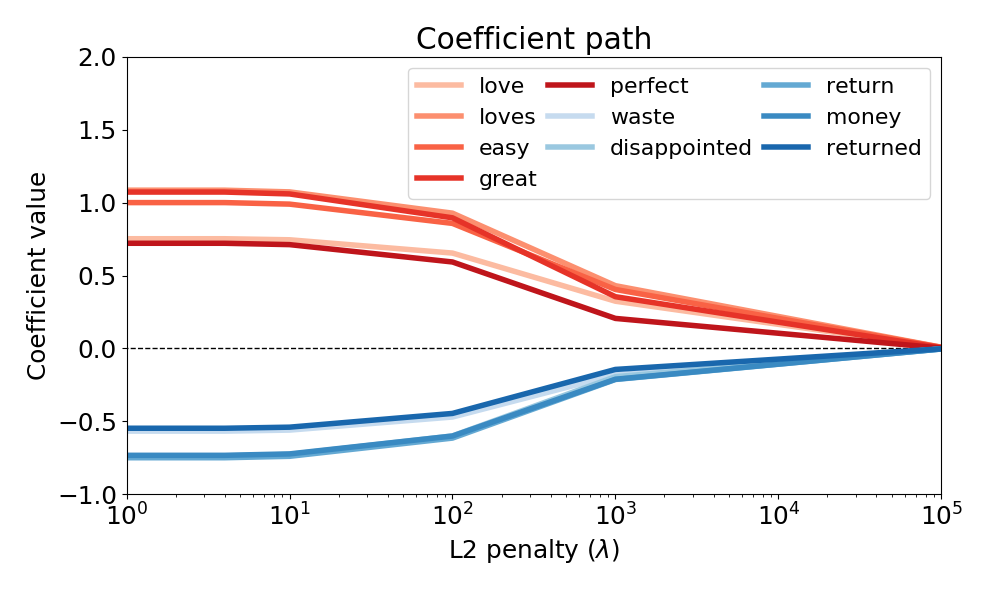

In [44]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

## Measuring accuracy

In [45]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [46]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [47]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7700715280564671, validation_accuracy = 0.7664083652320045
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7699771015792828, validation_accuracy = 0.7663150032676688
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7698354618635065, validation_accuracy = 0.7664083652320045
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7683246382285593, validation_accuracy = 0.7661282793389973
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7572295271594155, validation_accuracy = 0.7584725982634675
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6534784353532731, validation_accuracy = 0.644664363738213
---------------------------